In [304]:

#импорт библиотек

import pandas as pd
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
import association_metrics as am
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [305]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
import association_metrics as am
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [306]:
# TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
# TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"
TRAIN = 'data\chocolate-rating\chocolate_train.csv'
TEST = 'data\chocolate-rating\chocolate_test_new.csv'

In [307]:
train_df = pd.read_csv(TRAIN)

In [308]:
test_df = pd.read_csv(TEST)

In [309]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


In [310]:
train_df.describe()

,REF,Review,Rating
count,1255.000000,1255.000000,1255.000000
mean,1045.152191,2012.382470,3.176494
std,551.284249,2.922499,0.478948
min,5.000000,2006.000000,1.000000
25%,593.000000,2010.000000,2.750000
50%,1077.000000,2013.000000,3.250000
75%,1514.000000,2015.000000,3.500000
max,1952.000000,2017.000000,5.000000


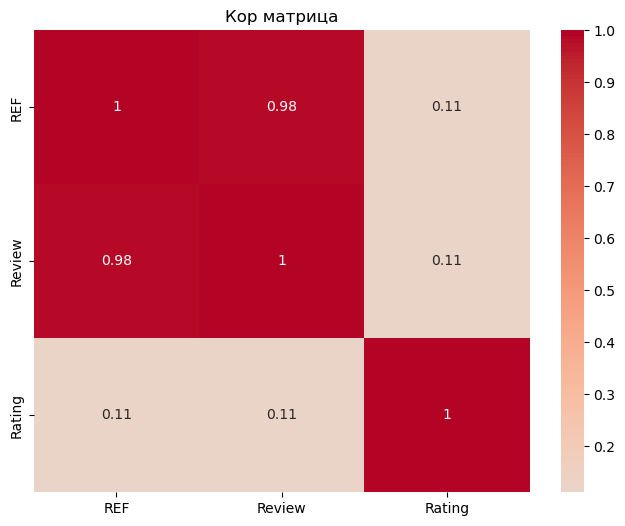

In [311]:
plt.figure(figsize=(8, 6))
correlation_matrix = train_df.corr(numeric_only=True)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Кор матрица')

plt.show()

In [312]:
train_df.dropna(axis=0, inplace=True)

Выделяем матрицу объект-признак и вектор с целевой переменной

In [313]:
y_train = train_df['Rating']
X_train = train_df.drop('Rating', axis=1)

In [314]:
X_train

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,Criollo,Indonesia
...,...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,Madagascar,363,2009,80%,U.K.,"Criollo, Trinitario",Madagascar
1251,Marana,Cusco,1884,2016,70%,Peru,,Peru
1252,Arete,Nacional,1534,2015,68%,U.S.A.,Forastero (Nacional),Peru
1253,Fresco,"Conacado, #212, LR, SC",642,2011,72%,U.S.A.,,Dominican Republic


Убираем пустые значения и преобразуем проценты в числовой столбец:

In [315]:
def clean(df):
    _df = df.copy()
    _df['Cocoa Percent_numeric'] = _df['Cocoa Percent'].str.rstrip('%').astype(float)
    _df['Broad Bean Origin_cat'] = _df['Broad Bean Origin'].str.split(',', expand=True)[0].replace('\xa0', np.nan)
    _df['Bean Type_cat'] = _df['Bean Type'].str.split(r'[ ,(]', expand=True)[0].replace('\xa0', np.nan)
    _df['Specific Bean Origin_cat'] = _df['Specific Bean Origin'].str.split(',', expand=True)[0].replace('\xa0', np.nan)
    _df['Review / REF'] = _df['Review'] / _df['REF']
    _df = _df.drop(['REF', 'Cocoa Percent', 'Bean Type', 'Broad Bean Origin', 'Specific Bean Origin'], axis=1)
    return _df

X_train_cleaned = clean(X_train)

In [316]:
discretizer = KBinsDiscretizer(n_bins=11, encode='ordinal', strategy='kmeans', random_state=42)
discretizer.fit(X_train_cleaned[['Cocoa Percent_numeric']])

X_train_cleaned['Cocoa Percent_numeric_binned'] = discretizer.transform(X_train_cleaned[['Cocoa Percent_numeric']])
X_train_cleaned.drop('Cocoa Percent_numeric', axis=1, inplace=True)

In [317]:
X_train_cleaned['Cocoa Percent_numeric_binned'].value_counts()

Cocoa Percent_numeric_binned
4.0     520
5.0     373
3.0     115
6.0      95
2.0      57
7.0      44
10.0     15
1.0      14
9.0      10
8.0       8
0.0       2
Name: count, dtype: int64

In [318]:
XC = X_train_cleaned.apply(lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(XC)
cramersv.fit()

,Company,Company Location,Broad Bean Origin_cat,Bean Type_cat,Specific Bean Origin_cat
Company,1.000000,0.999651,0.633931,0.816914,0.653217
Company Location,0.999651,1.000000,0.378944,0.268613,0.735872
Broad Bean Origin_cat,0.633931,0.378944,1.000000,0.506266,0.976352
Bean Type_cat,0.816914,0.268613,0.506266,1.000000,0.871187
Specific Bean Origin_cat,0.653217,0.735872,0.976352,0.871187,1.000000


In [319]:
X_train_cleaned.drop('Broad Bean Origin_cat', axis=1, inplace=True)

In [320]:
X_train_cleaned['Bean Type_cat'] = X_train_cleaned.groupby(['Specific Bean Origin_cat'])['Bean Type_cat'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
)

X_train_cleaned['Bean Type_cat'] = X_train_cleaned['Bean Type_cat'].fillna('UNKNOWN')

## Обучение модели (распараллелим на все ядра и поставим обучаться)


In [321]:
X_train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1253 entries, 0 to 1254
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Company                       1253 non-null   object 
 1   Review                        1253 non-null   int64  
 2   Company Location              1253 non-null   object 
 3   Bean Type_cat                 1253 non-null   object 
 4   Specific Bean Origin_cat      1253 non-null   object 
 5   Review / REF                  1253 non-null   float64
 6   Cocoa Percent_numeric_binned  1253 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 78.3+ KB


In [322]:
X_train_cleaned

,Company,Review,Company Location,Bean Type_cat,Specific Bean Origin_cat,Review / REF,Cocoa Percent_numeric_binned
0,Willie's Cacao,2009,U.K.,Trinitario,Rio Caribe,4.396061,5.0
1,Beschle (Felchlin),2010,Switzerland,Criollo,Ocumare,3.956693,5.0
2,Dark Forest,2015,U.S.A.,Criollo,Tanzania,1.296654,4.0
3,Brasstown aka It's Chocolate,2013,U.S.A.,Trinitario,Cooproagro,1.789333,5.0
4,Pralus,2006,France,Criollo,Java,62.687500,5.0
...,...,...,...,...,...,...,...
1250,Artisan du Chocolat,2009,U.K.,Criollo,Madagascar,5.534435,6.0
1251,Marana,2016,Peru,UNKNOWN,Cusco,1.070064,4.0
1252,Arete,2015,U.S.A.,Forastero,Nacional,1.313559,4.0
1253,Fresco,2011,U.S.A.,Trinitario,Conacado,3.132399,5.0


In [323]:
cat_features = X_train_cleaned.select_dtypes(exclude='number').columns.tolist()

In [324]:
# cat_features = [0, 2, 3, 4]
# model = CatBoostRegressor(cat_features=cat_features)
# model.fit(X_train_cleaned, y_train)

In [325]:
import optuna
from sklearn.metrics import mean_squared_error
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'depth': trial.suggest_int('depth', 2, 5),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
        'cat_features': cat_features,
        'random_state': 42
    }
    model = CatBoostRegressor(**params,thread_count=-1)
    model.fit(X_train_cleaned, y_train, use_best_model=True)

    preds = model.predict(X_train_cleaned)

    rmse = mean_squared_error(y_train, preds, )
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10,n_jobs=-1,timeout=600)  

print('Лучшее значение RMSE: {}'.format(study.best_value))
print('Лучшие параметры: ')
for key, value in study.best_params.items():
    print('    {}: {}'.format(key, value))

best_params = study.best_params
best_params['cat_features'] = cat_features
best_params['task_type'] = 'CPU'
best_params['random_state'] = 42
best_params['verbose'] = True

model = CatBoostRegressor(**best_params,thread_count=28)
model.fit(X_train_cleaned, y_train)

[I 2025-11-17 16:12:37,723] A new study created in memory with name: no-name-3c2a44b7-9e89-4e7b-8659-c989e0ca1bcf


0:	learn: 0.4779620	total: 23.9ms	remaining: 13.3s
0:	learn: 0.4773151	total: 20.1ms	remaining: 31.7s
0:	learn: 0.4781483	total: 17.7ms	remaining: 30.5s
1:	learn: 0.4777591	total: 32.8ms	remaining: 9.09s
0:	learn: 0.4781837	total: 7.09ms	remaining: 7.53s
1:	learn: 0.4765636	total: 28.8ms	remaining: 22.7s
0:	learn: 0.4781674	total: 11.2ms	remaining: 10.6s
1:	learn: 0.4781092	total: 24.9ms	remaining: 21.4s
0:	learn: 0.4779902	total: 32.4ms	remaining: 40s
0:	learn: 0.4780158	total: 7.15ms	remaining: 10.2s
2:	learn: 0.4774813	total: 42ms	remaining: 7.75s
1:	learn: 0.4781761	total: 17.2ms	remaining: 9.11s
0:	learn: 0.4776771	total: 7.35ms	remaining: 12.4s
2:	learn: 0.4780560	total: 31.4ms	remaining: 18s
2:	learn: 0.4755168	total: 38.1ms	remaining: 20.1s
1:	learn: 0.4778599	total: 13.8ms	remaining: 9.84s
1:	learn: 0.4772288	total: 13.6ms	remaining: 11.5s
2:	learn: 0.4781658	total: 23.9ms	remaining: 8.44s
0:	learn: 0.4781877	total: 22.5ms	remaining: 15.2s
1:	learn: 0.4781470	total: 27.4ms	rem

You should provide test set for use best model. use_best_model parameter has been switched to false value.
You should provide test set for use best model. use_best_model parameter has been switched to false value.
You should provide test set for use best model. use_best_model parameter has been switched to false value.
You should provide test set for use best model. use_best_model parameter has been switched to false value.
You should provide test set for use best model. use_best_model parameter has been switched to false value.
You should provide test set for use best model. use_best_model parameter has been switched to false value.
You should provide test set for use best model. use_best_model parameter has been switched to false value.
You should provide test set for use best model. use_best_model parameter has been switched to false value.
You should provide test set for use best model. use_best_model parameter has been switched to false value.
You should provide test set for use b

8:	learn: 0.4780965	total: 103ms	remaining: 12.1s
9:	learn: 0.4689870	total: 130ms	remaining: 20.4s
9:	learn: 0.4776431	total: 123ms	remaining: 21.1s
9:	learn: 0.4753948	total: 135ms	remaining: 7.37s
7:	learn: 0.4764828	total: 104ms	remaining: 18.4s
7:	learn: 0.4736867	total: 99.7ms	remaining: 21s
6:	learn: 0.4779968	total: 116ms	remaining: 15.5s
9:	learn: 0.4780854	total: 114ms	remaining: 12s
3:	learn: 0.4775265	total: 96ms	remaining: 4.82s
10:	learn: 0.4751130	total: 148ms	remaining: 7.32s
10:	learn: 0.4775856	total: 137ms	remaining: 21.3s
8:	learn: 0.4730589	total: 113ms	remaining: 21.1s
10:	learn: 0.4680768	total: 143ms	remaining: 20.5s
8:	learn: 0.4762491	total: 117ms	remaining: 18.4s
4:	learn: 0.4781684	total: 122ms	remaining: 16.5s
10:	learn: 0.4780741	total: 124ms	remaining: 11.9s
7:	learn: 0.4779819	total: 130ms	remaining: 15.3s
4:	learn: 0.4771350	total: 154ms	remaining: 37.9s
11:	learn: 0.4675957	total: 154ms	remaining: 20.2s
11:	learn: 0.4748779	total: 161ms	remaining: 7.29

[I 2025-11-17 16:12:43,139] Trial 9 finished with value: 0.18906300932871936 and parameters: {'iterations': 205, 'depth': 4, 'learning_rate': 0.003910132406026965}. Best is trial 9 with value: 0.18906300932871936.


405:	learn: 0.4232500	total: 5.21s	remaining: 16.5s
409:	learn: 0.4394618	total: 5.21s	remaining: 12.9s
277:	learn: 0.4703787	total: 5.25s	remaining: 12.6s
401:	learn: 0.4742865	total: 5.23s	remaining: 8.61s
398:	learn: 0.4151155	total: 5.26s	remaining: 15.6s
404:	learn: 0.4354220	total: 5.26s	remaining: 1.96s
402:	learn: 0.4619250	total: 5.25s	remaining: 17.2s
406:	learn: 0.4232352	total: 5.23s	remaining: 16.5s
410:	learn: 0.4394025	total: 5.24s	remaining: 12.9s
205:	learn: 0.4769901	total: 5.29s	remaining: 12.1s
278:	learn: 0.4703487	total: 5.27s	remaining: 12.6s
166:	learn: 0.4452515	total: 5.32s	remaining: 34.1s
405:	learn: 0.4353477	total: 5.28s	remaining: 1.95s
399:	learn: 0.4150811	total: 5.27s	remaining: 15.6s
403:	learn: 0.4618924	total: 5.26s	remaining: 17.2s
402:	learn: 0.4742777	total: 5.25s	remaining: 8.59s
411:	learn: 0.4393660	total: 5.25s	remaining: 12.9s
407:	learn: 0.4231987	total: 5.24s	remaining: 16.5s
400:	learn: 0.4150517	total: 5.28s	remaining: 15.6s
403:	learn: 

[I 2025-11-17 16:12:45,168] Trial 0 finished with value: 0.1617351008217677 and parameters: {'iterations': 556, 'depth': 2, 'learning_rate': 0.00634544183706447}. Best is trial 0 with value: 0.1617351008217677.


545:	learn: 0.4099577	total: 7.14s	remaining: 13.5s
552:	learn: 0.4184099	total: 7.11s	remaining: 14.7s
546:	learn: 0.4729730	total: 7.12s	remaining: 6.71s
550:	learn: 0.4577857	total: 7.13s	remaining: 15.1s
548:	learn: 0.4302991	total: 7.15s	remaining: 91.2ms
555:	learn: 0.4341928	total: 7.11s	remaining: 11.1s
279:	learn: 0.4765461	total: 7.18s	remaining: 10.2s
378:	learn: 0.4678410	total: 7.16s	remaining: 10.7s
546:	learn: 0.4099273	total: 7.15s	remaining: 13.5s
556:	learn: 0.4341397	total: 7.13s	remaining: 11.1s
547:	learn: 0.4729632	total: 7.13s	remaining: 6.7s
553:	learn: 0.4184065	total: 7.12s	remaining: 14.6s
226:	learn: 0.4381882	total: 7.21s	remaining: 32.1s
549:	learn: 0.4302693	total: 7.16s	remaining: 78.2ms
551:	learn: 0.4577696	total: 7.16s	remaining: 15.2s
547:	learn: 0.4099057	total: 7.17s	remaining: 13.5s
379:	learn: 0.4678164	total: 7.18s	remaining: 10.7s
548:	learn: 0.4729575	total: 7.14s	remaining: 6.69s
557:	learn: 0.4341169	total: 7.14s	remaining: 11.1s
554:	learn:

[I 2025-11-17 16:12:51,423] Trial 5 finished with value: 0.21471949003552548 and parameters: {'iterations': 1063, 'depth': 2, 'learning_rate': 0.00023393545587541457}. Best is trial 0 with value: 0.1617351008217677.
[I 2025-11-17 16:12:54,511] Trial 7 finished with value: 0.22310717889915993 and parameters: {'iterations': 678, 'depth': 4, 'learning_rate': 0.00010967418951832186}. Best is trial 0 with value: 0.1617351008217677.
[I 2025-11-17 16:12:55,208] Trial 4 finished with value: 0.19828773572656508 and parameters: {'iterations': 944, 'depth': 3, 'learning_rate': 0.0006049984332004484}. Best is trial 0 with value: 0.1617351008217677.
[I 2025-11-17 16:12:55,599] Trial 6 finished with value: 0.14733980849217815 and parameters: {'iterations': 1423, 'depth': 2, 'learning_rate': 0.0048606307829178125}. Best is trial 6 with value: 0.14733980849217815.
[I 2025-11-17 16:12:57,410] Trial 1 finished with value: 0.12497493671561757 and parameters: {'iterations': 1582, 'depth': 2, 'learning_rat

Лучшее значение RMSE: 0.12497493671561757
Лучшие параметры: 
    iterations: 1582
    depth: 2
    learning_rate: 0.024339585365762726
0:	learn: 0.4773151	total: 5.22ms	remaining: 8.26s
1:	learn: 0.4765636	total: 9.82ms	remaining: 7.76s
2:	learn: 0.4755168	total: 14.1ms	remaining: 7.4s
3:	learn: 0.4744270	total: 22.4ms	remaining: 8.85s
4:	learn: 0.4737719	total: 30.5ms	remaining: 9.61s
5:	learn: 0.4727608	total: 38.1ms	remaining: 10s
6:	learn: 0.4716941	total: 44.5ms	remaining: 10s
7:	learn: 0.4707433	total: 52.5ms	remaining: 10.3s
8:	learn: 0.4698076	total: 59.4ms	remaining: 10.4s
9:	learn: 0.4689870	total: 67.5ms	remaining: 10.6s
10:	learn: 0.4680768	total: 74.5ms	remaining: 10.6s
11:	learn: 0.4675957	total: 82.2ms	remaining: 10.8s
12:	learn: 0.4667451	total: 89.3ms	remaining: 10.8s
13:	learn: 0.4660205	total: 97.7ms	remaining: 10.9s
14:	learn: 0.4655725	total: 107ms	remaining: 11.1s
15:	learn: 0.4648556	total: 114ms	remaining: 11.1s
16:	learn: 0.4642063	total: 120ms	remaining: 11.1s

In [326]:
model.score(X_train_cleaned, y_train)

0.453465078547981

## тест


In [327]:
# test_df = pd.read_csv("/kaggle/input/chocolate-rating-prediction-ai-edu/chocolate_test_new.csv")

In [328]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Company               540 non-null    object
 1   Specific Bean Origin  540 non-null    object
 2   REF                   540 non-null    int64 
 3   Review                540 non-null    int64 
 4   Cocoa Percent         540 non-null    object
 5   Company Location      540 non-null    object
 6   Bean Type             540 non-null    object
 7   Broad Bean Origin     540 non-null    object
dtypes: int64(2), object(6)
memory usage: 33.9+ KB


In [329]:
X_test_cleaned = clean(test_df)
X_test_cleaned['Cocoa Percent_numeric_binned'] = discretizer.transform(X_test_cleaned[['Cocoa Percent_numeric']])
X_test_cleaned.drop(['Broad Bean Origin_cat', 'Cocoa Percent_numeric'], axis=1, inplace=True)

In [330]:
X_test_cleaned['Bean Type_cat'] = X_test_cleaned.groupby(['Specific Bean Origin_cat'])['Bean Type_cat'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
)

X_test_cleaned['Bean Type_cat'] = X_test_cleaned['Bean Type_cat'].fillna('UNKNOWN')

In [331]:
X_test_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Company                       540 non-null    object 
 1   Review                        540 non-null    int64  
 2   Company Location              540 non-null    object 
 3   Bean Type_cat                 540 non-null    object 
 4   Specific Bean Origin_cat      540 non-null    object 
 5   Review / REF                  540 non-null    float64
 6   Cocoa Percent_numeric_binned  540 non-null    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 29.7+ KB


Делаем предсказание

In [332]:
pred = model.predict(X_test_cleaned)

Сохраняем предсказание в файл в нужном формате

In [333]:
test_df['id'] = np.arange(len(test_df))
test_df['Rating'] = pred

test_df[['id','Rating']].to_csv("submission.csv", index=False)